# ECS759P: _Artificial Intelligence_<br>Assignment 2, Question 2

## On convolutional neural networks (CNN)

**Convolution operation**

A convolution operation between two matrices with the same dimensionality is the operation which produces a new matrix of the same dimensionality by multiplying each element $[i, j]$ of one to the element $[i, j]$ of the other.

---

**Convolution for feature extraction**

The key application of convlution is its usage in identifying features from a matrix $M$. It does so by using a filter matrix (i.e. a matrix representing or approximating the feature to be identified) and applying convolution between this filter matrix and each submatrix of $M$ separated by a step $k_1$ (i.e. we go through the submatrices matrix $M$ whose first (top-left-most) cells are separated by $k_1-1$ cells).

At each level of abstraction, we apply $n$ filters to help identify $n$ features in the matrix $M$. To elaborate, we start by identifying $n_1$ filters to help identify $n_1$ features that are more concrete, i.e. less generalised; these are smaller more perceptual features that constitute larger more conceptual features. Then, we stack/combine the results of each feature detection in a clear order, thus obtaining another matrix from which we can extract higher-level features with the same basic method, i.e. filter-based convolution. We repeat this until we have generalised the process for a whole entity (_which is defined by the various features we extracted_).

At the end of this process, we obtain a matrix $M^*$ whose values are the result of filtering out much of noise and irrelevant/non-essential details from the original matrix $M$. This creates much more efficient training data for the neural network (NN). In other words, convolutional neural networks (CNN) map a complex, potentially noisy input matrix to a simpler, potentially less noisy output matrix that is much more feasible for a fully-connected NN to handle.

---

**Pooling after feature extraction**

Furthermore, we can apply pooling, i.e. the process of generalising fixed-sized clusters of $M^*$ separated by a step $k_2$. This generalisation can be done in many ways:

- Getting the maximum of the cluster
- Averaging the values of the cluster
- etc.

Pooling does the following:

- Reduces dimensions & computational complexity
- Reduces parameters to fit over, reducing overfitting
- The above implies that the model is more tolerant toward variation or distortion

---

**Applying resultant data for fully-connected neural network**

Note that the power of a NN is in estimating and generalising an arbitrarily complex, non-linear function that maps a input vector to an output vector. This is vital since many classification problems (ex. image recognition) do not involve linearly separable data points, requiring a non-linear classification. By abstracting the more essential elements from the input matrix, CNN and pooling reduce the complexity of the input both for training and application, enabling a more efficient generalisation and thus a quicker, more accurate estimation of the classification function.

---

**General notes**

- A model can consist of multiple CNN layers
- A model can consist of multiple fully-connected NNs (FCNNs)

---

> REFERENCE: https://www.youtube.com/watch?v=zfiSAzpy9NM

## Key terminology

- **Stride**: The step/dimensions by which each submatrix/cluster of the data is to be separated for filtering or pooling
- **Kernel**: The size of the cluster/filter matrix in the CNN or pooling layer

## Accessing the data

In [97]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pandas import DataFrame

train_set = torchvision.datasets.FashionMNIST(root = ".",
                                              train=True,
                                              download=True,
                                              transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".",
                                             train=False,
                                             download=True,
                                             transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=32,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=32,
                                          shuffle=False)
# Fix the seed to be able to get the same randomness across runs
# and hence reproducible outcomes
torch.manual_seed(0)


# If you are using CuDNN , otherwise you can just ignore
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

Having a look at the images the data consists of...

Label is: 3
Dimension of input data: torch.Size([32, 1, 28, 28])
Dimension of labels: torch.Size([32])


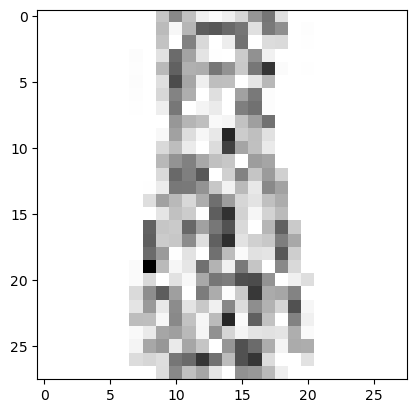

In [2]:
input_data, label = next(iter(train_loader))
plt.imshow(input_data[0,:,:,:].numpy().reshape(28,28), cmap="gray_r");
print("Label is: {}".format(label[0]))
print("Dimension of input data: {}".format(input_data.size()))
print("Dimension of labels: {}".format(label.size()))

## Creating the model

In [73]:
class CNN(nn.Module):
  def __init__(self, activation=nn.ReLU, dropout=0):
    super(CNN, self).__init__()
    # CNN layers:
    self.cnn = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1),
                             activation(),
                             nn.MaxPool2d(kernel_size=2, stride=2),
                             nn.Conv2d(32, 64, kernel_size=5, stride=1),
                             activation(),
                             nn.MaxPool2d(kernel_size=2, stride=2))

    # Fully-connected NN layers:
    self.fcnn = nn.Sequential(nn.Linear(1024, 1024),  # 1st layer
                              activation(),
                              nn.Linear(1024, 256),   # 2nd layer
                              activation(),
                              nn.Dropout(p=dropout),
                              nn.Linear(256, 10))     # Output layer

    # The processor architecture to use:
    self.device = torch.device("cuda:0")
  #================================================

  # Forward method:
  def forward(self, x):
    x = self.cnn(x)
    x = x.view(x.size(0), -1)
    x = self.fcnn(x)
    return x

  #================================================

  # Helper function to initialise weights of each layer:
  def __init_weights(self, model):
    # Initialise linear or convolutional layer:
    if isinstance(model, nn.Linear) or isinstance(model, nn.Conv2d):
        torch.nn.init.xavier_normal_(model.weight)

  #================================================

  # Function to evaluate the accuracy of the predictions:
  # NOTE: Accuracy = Correct predictions / Total predictions
  '''
  REFERENCE FOR CODE:
  Following code taken from `Lab7_CNN_Classification_task_solutions.ipynb`
  '''
  def evaluate(self, dataloader):
    total, correct = 0,0
    # Turn on evaluate mode, this de-activates certain modes such as dropout:
    # NOTE: This is good practice to include in your projects
    self.eval()
    for data in dataloader:

      inputs, labels = data
      inputs, labels = inputs.to(self.device), labels.to(self.device)
      net = self.to(self.device)
      outputs = net(inputs)
      '''
      NOTE ON THE ABOVE:
      We take the index of the class that received the highest value. We take
      `outputs.data` so that no backpropagation is performed for these outputs.
      '''
      _, pred = torch.max(outputs.data, 1)
      total += labels.size(0)
      # .item() takes Python float values from the tensor
      correct += (pred == labels).sum().item()
    return 100*correct/total # Returning as percentage

  #================================================

  # Training loop:
  def trainingLoop(self, trainLoader, testLoader, nEpochs=30, lr=0.1):
    # Optimiser (i.e. method of updating & optimising weights):
    # NOTE: We shall be using stochastic gradient descent
    net = self.to(self.device)
    # Initialise weights:
    net.apply(self.__init_weights)
    optimiser = torch.optim.SGD(self.parameters(), lr=lr)
    #------------------------------------
    # Loss function:
    # NOTE: We shall be using cross-entropy loss
    loss = nn.CrossEntropyLoss()
    loss.to(self.device)
    #------------------------------------
    # Training loop:
    epochLossList, trainAccuracy, testAccuracy = [], [], []
    i_prev = 0
    # The main loop:
    print('[', end='')
    for i in range(nEpochs):
      epochLoss = 0
      # Progress bar (maximum length=30):
      if int(i/(nEpochs/30)) > int(i_prev/(nEpochs/30)): print('.', end='')
      i_prev = i
      for j, data in enumerate(trainLoader):
        # Initialisation:
        self.train() # Setting the model to training mode
        inputs, labels = data
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        optimiser.zero_grad() # Resetting calculated gradients to zero

        # Predictions:
        outputs = self.forward(inputs)

        # Backpropagation:
        L = loss(outputs, labels)
        L.backward()
        optimiser.step()
        epochLoss += L.item()

      epochLossList.append(epochLoss)
      trainAccuracy.append(self.evaluate(trainLoader))
      testAccuracy.append(self.evaluate(testLoader))
    print(']')
    return {"epochLossList":epochLossList,
            "trainAccuracy":trainAccuracy,
            "testAccuracy":testAccuracy}

**PROGRAMMING NOTE 1**: **Format for** `kernel_size`, `stride`, **etc.**<br>The parameters `kernel_size`, `stride`, `padding` and `dilation` can either be:

- A single integer (_here, the same value is used for the height and width dimension_)
- A tuple of two integers (_here, the 1st integer is used for the height dimension, and the 2nd integer for the width dimension_)

---

**PROGRAMMING NOTE 2**: `torch.Tensor.view`:<br>
Returns a new tensor with the same data as the calling tensor object but of a different shape.

> REFERENCE: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

In [4]:
M1 = CNN()
R1 = M1.trainingLoop(train_loader, test_loader, nEpochs=30)

[.............................]


### Plotting the loss & accuracy over epochs

Small helper function to make the plot presentable...

In [5]:
def _(title, xlabel, ylabel, legend=False):
    plt.title(title)
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    if legend: plt.legend()
    plt.show()

Plotting the loss values per epoch...

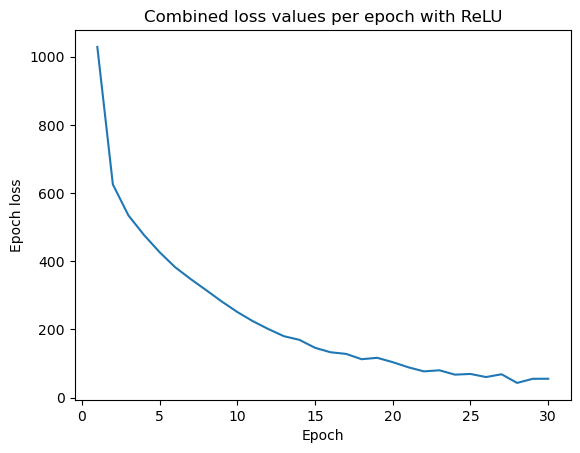

In [111]:
plt.plot(range(1, len(R1["epochLossList"])+1), R1["epochLossList"])
_("Combined loss values per epoch with ReLU", "Epoch", "Epoch loss")

Plotting the accuracy of classification over epochs...

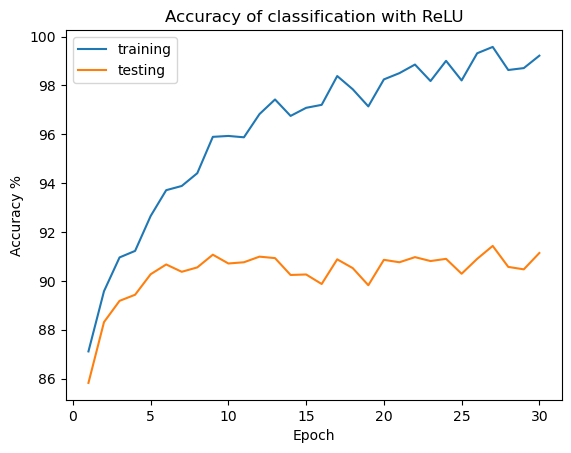

In [13]:
plt.plot(range(1, len(R1["trainAccuracy"])+1), R1["trainAccuracy"], label="training")
plt.plot(range(1, len(R1["testAccuracy"])+1), R1["testAccuracy"], label="testing")
_("Accuracy of classification with ReLU", "Epoch", "Accuracy %", legend=True)

### Comparing with ELU activation function

In [9]:
M2 = CNN(activation=nn.ELU)
R2 = M2.trainingLoop(train_loader, test_loader, nEpochs=30)

[.............................]


In [107]:
DataFrame(data={"Activation":["ELU", "ReLU"],
                "Final train accuracy":[R1["trainAccuracy"][-1], R2["trainAccuracy"][-1]],
                "Final test accuracy":[R1["testAccuracy"][-1], R2["testAccuracy"][-1]]},
          index=["Model M1", "Model M2"])

,Activation,Final train accuracy,Final test accuracy
Model M1,ELU,99.218333,91.14
Model M2,ReLU,98.913333,90.26


Some extra visualisation...

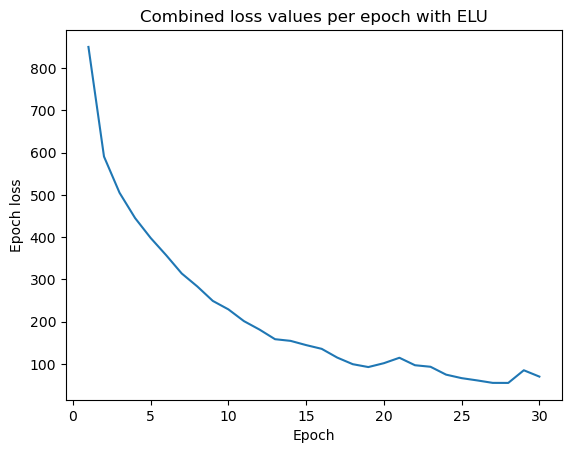

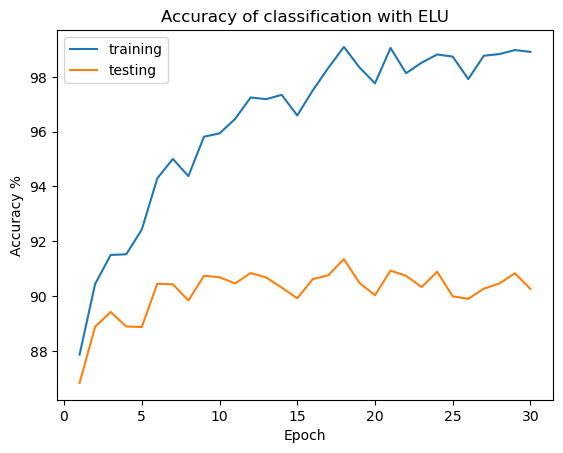

In [109]:
plt.plot(range(1, len(R2["epochLossList"])+1), R2["epochLossList"])
_("Combined loss values per epoch with ELU", "Epoch", "Epoch loss")

plt.plot(range(1, len(R2["trainAccuracy"])+1), R2["trainAccuracy"], label="training")
plt.plot(range(1, len(R2["testAccuracy"])+1), R2["testAccuracy"], label="testing")
_("Accuracy of classification with ELU", "Epoch", "Accuracy %", legend=True)

### Comparing different learning rates

In [72]:
"""
from copy import deepcopy
# Reducing the size of the training data set:
nTrain = len(train_loader.dataset)
trainLoader = deepcopy(train_loader)
trainLoader.dataset.data = train_loader.dataset.data[:int(nTrain/2)]
"""

R = [] # For storing the results of each
for lr in [0.001, 0.1, 0.5, 1.0, 10.0]:
    M = CNN(activation=nn.ReLU)
    R.append(M.trainingLoop(train_loader, test_loader, nEpochs=30, lr=lr))

[.............................]
[.............................]
[.............................]
[.............................]
[.............................]


### Testing dropout

In [75]:
myCNN = CNN(activation=nn.ReLU, dropout=0.3)
R3 = myCNN.trainingLoop(train_loader, test_loader, nEpochs=30, lr=0.1)

[.............................]


In [106]:
DataFrame(data={"Dropout":[0, 0.3],
                "Final cost":[R1["epochLossList"][-1], R3["epochLossList"][-1]],
                "Final train accuracy":[R1["trainAccuracy"][-1], R3["trainAccuracy"][-1]],
                "Final test accuracy":[R1["testAccuracy"][-1], R3["testAccuracy"][-1]]},
          index=["Model M1", "Model M3"])

,Dropout,Final cost,Final train accuracy,Final test accuracy
Model M1,0.0,55.392490,99.218333,91.14
Model M3,0.3,75.407446,98.861667,90.53


Some extra visualisation...

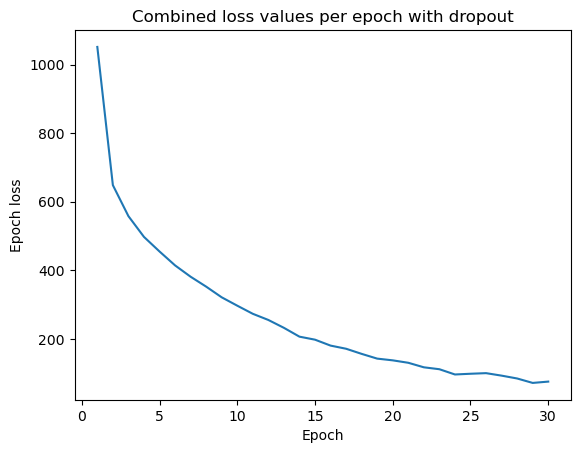

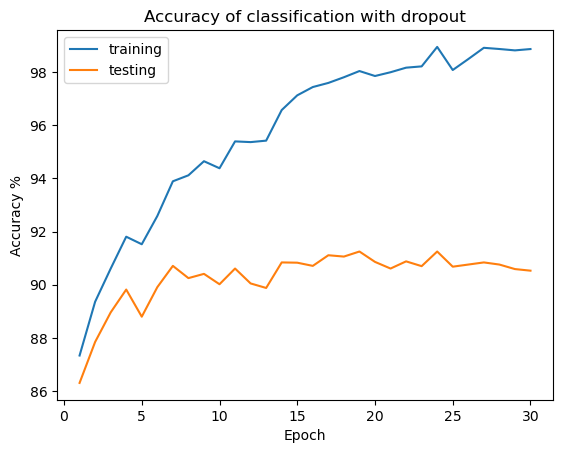

In [96]:
plt.plot(range(1, len(R3["epochLossList"])+1), R3["epochLossList"])
_("Combined loss values per epoch with dropout", "Epoch", "Epoch loss")

plt.plot(range(1, len(R3["trainAccuracy"])+1), R3["trainAccuracy"], label="training")
plt.plot(range(1, len(R3["testAccuracy"])+1), R3["testAccuracy"], label="testing")
_("Accuracy of classification with dropout", "Epoch", "Accuracy %", legend=True)